# Lightweight Fine-Tuning Project

Below I list the PEFT technique, the model, evaluation approach and fine-tunning dataset I'll be using to fine tune the LLM
* PEFT technique: LoRA
* Model: Llama 3.1 8B
* Evaluation approach: Hugging Face Trainer.evaluate
* Fine-tuning dataset: [AuthorMix](https://huggingface.co/datasets/hallisky/AuthorMix)

## Loading and Evaluating a Foundation Model

Loading Llama 3.1 8B model and evaluate its performance prior to fine-tuning. This includes loading an appropriate tokenizer and dataset.

## Load in IMDB Dataset

In [ ]:
# Install dependencies
!pip install -q "datasets>=2.16.1"
!pip install torch
!pip install transformers==4.44.1
!pip install python-dotenv
!pip install peft
!pip install evaluate

In [1]:
from datasets import load_dataset

# Load the train and test splits of the imdb dataset
splits = ["train", "test"]
ds = {
    split: ds for split,
    ds in zip(splits, load_dataset("hallisky/AuthorMix", split=splits))
}

# Thin out the dataset to make it run faster for this example
for split in splits:
    ds[split] = ds[split].shuffle(seed=42).select(range(1000))

# Show the dataset
ds

{'train': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 1000
 }),
 'test': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 1000
 })}

### Dataset Exploration

In [2]:
import pandas as pd

train_df = pd.DataFrame(ds['train'])

print(train_df.head())

       style                                               text category
0  blog11518  "Jamaia....come and help me talk some sense in...     blog
1  blog25872  I decided I wasn't going to go to Boler today....     blog
2      obama  For over two decades, bin Laden has been al Qa...   speech
3  blog11518  motion with precise timing. Sucking the cigare...     blog
4  blog11518  "So what, we just stand here?" Alyx prompts, h...     blog


The dataset contains 14 unique authors

In [3]:
unique_styles = train_df['style'].unique()
print(unique_styles)

['blog11518' 'blog25872' 'obama' 'fitzgerald' 'hemingway' 'woolf' 'bush'
 'blog30102' 'blog5546' 'trump' 'blog30407' 'qq' 'pp' 'h']


In 4 number of formats/categories

In [4]:
unique_formats = train_df['category'].unique()
print(unique_formats)

['blog' 'speech' 'author' 'amt']


Dataset sample text length just skew towards 335 characters or less 

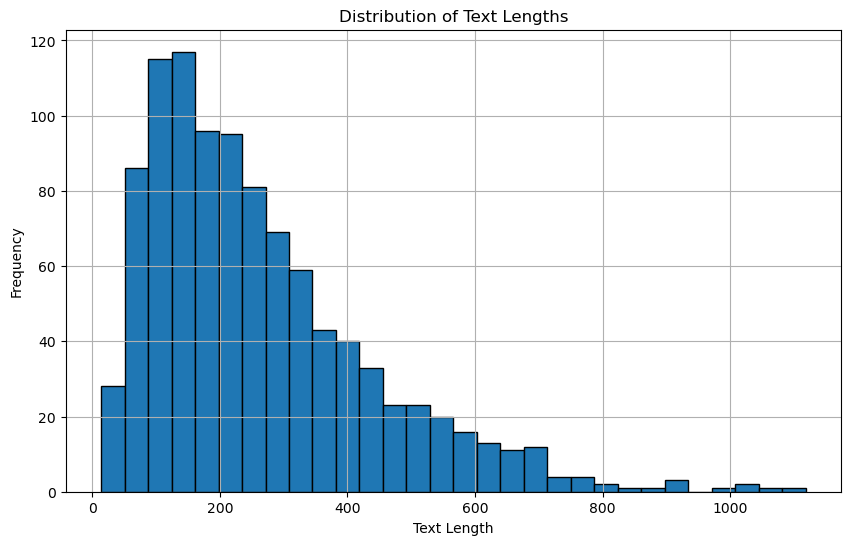

In [5]:
import matplotlib.pyplot as plt

train_df['text_length'] = train_df['text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=30, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Intial Llama 3.1 8B/GPT-2 evaluation on the dataset
Going to load in the Llama/GPT-2 model through AutoModelForSequenceClassification and set the label ids

In [6]:
import torch
import os
from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv("env.txt")
hf_token = os.getenv('HF_API_TOKEN')
login(hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/david/.cache/huggingface/token
Login successful


In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification

num_labels = len(unique_styles)
id2label = {i: style for i, style in enumerate(unique_styles)}
label2id = {v: k for k, v in id2label.items()}
print(f"num_labels: {num_labels}")
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")
llama_model_key = "meta-llama/Meta-Llama-3.1-8B"
gpt_model_key = "openai-community/gpt2"
gpt_model = AutoModelForSequenceClassification.from_pretrained(
    gpt_model_key,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    token=True,
)
llama_model = AutoModelForSequenceClassification.from_pretrained(
    llama_model_key,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    token=True,
)

num_labels: 14
id2label: {0: 'blog11518', 1: 'blog25872', 2: 'obama', 3: 'fitzgerald', 4: 'hemingway', 5: 'woolf', 6: 'bush', 7: 'blog30102', 8: 'blog5546', 9: 'trump', 10: 'blog30407', 11: 'qq', 12: 'pp', 13: 'h'}
label2id: {'blog11518': 0, 'blog25872': 1, 'obama': 2, 'fitzgerald': 3, 'hemingway': 4, 'woolf': 5, 'bush': 6, 'blog30102': 7, 'blog5546': 8, 'trump': 9, 'blog30407': 10, 'qq': 11, 'pp': 12, 'h': 13}


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Tokenizer setup
# GPT
gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_model_key, token=True)
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
gpt_model.config.pad_token_id = gpt_tokenizer.pad_token_id

#llama
llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_key, token=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_model.config.pad_token_id = llama_tokenizer.pad_token_id


/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
def get_prediction(model, text, tokenizer):
    # Ensure the text is correctly passed as a string
    if not isinstance(text, str):
        raise ValueError("Input text must be a string")

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Perform the prediction (get the logits)
    outputs = model(**inputs)

    # Get the predicted class (assuming this is for classification)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=-1)

    return predicted_class

In [10]:
ds['test'][15]

{'style': 'woolf',
 'text': '"It\'s his way of making friends, I suppose," she laughed. "Well--I shall do my part. I shall begin--\'Ugly in body, repulsive in mind as you are, Mr. Hirst--\'"',
 'category': 'author'}

In [12]:
prediction = get_prediction(llama_model, ds['test'][15]['text'], llama_tokenizer)
prediction

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


tensor([7])

In [10]:
import time

def evaluate_model(dataset, model, tokenizer, n=10):
    correct_predictions = 0

    # Iterate over the first 'n' samples of the dataset
    for i in range(n):
        # Get the input text and true label from the dataset
        text = dataset['test'][i]['text']
        true_label = dataset['test'][i]['style']  # Assuming 'style' is the label field

        # If the text is not a string, join it into a string
        if isinstance(text, list):
            text = " ".join(text)

        # Get the model's prediction
        predicted_class = get_prediction(model, text, tokenizer)

        # Check if the prediction is correct
        if predicted_class.item() == label2id[true_label]:  # Convert tensor to scalar with .item()
            correct_predictions += 1

    # Return the accuracy of the model on 'n' samples
    accuracy = correct_predictions / n
    return accuracy

### Llama Pre-Training Accuracy

In [14]:
evaluate_model(ds, model=llama_model, tokenizer=llama_tokenizer, n=10)

0.0

### GPT Pre-Training Accuracy

In [15]:
evaluate_model(ds, model=gpt_model, tokenizer=gpt_tokenizer, n=10)

0.2

### Setup PEFT Models

#### Get modules to target

In [11]:
for name, module in gpt_model.named_modules():
    print(name)


transformer
transformer.wte
transformer.wpe
transformer.drop
transformer.h
transformer.h.0
transformer.h.0.ln_1
transformer.h.0.attn
transformer.h.0.attn.c_attn
transformer.h.0.attn.c_proj
transformer.h.0.attn.attn_dropout
transformer.h.0.attn.resid_dropout
transformer.h.0.ln_2
transformer.h.0.mlp
transformer.h.0.mlp.c_fc
transformer.h.0.mlp.c_proj
transformer.h.0.mlp.act
transformer.h.0.mlp.dropout
transformer.h.1
transformer.h.1.ln_1
transformer.h.1.attn
transformer.h.1.attn.c_attn
transformer.h.1.attn.c_proj
transformer.h.1.attn.attn_dropout
transformer.h.1.attn.resid_dropout
transformer.h.1.ln_2
transformer.h.1.mlp
transformer.h.1.mlp.c_fc
transformer.h.1.mlp.c_proj
transformer.h.1.mlp.act
transformer.h.1.mlp.dropout
transformer.h.2
transformer.h.2.ln_1
transformer.h.2.attn
transformer.h.2.attn.c_attn
transformer.h.2.attn.c_proj
transformer.h.2.attn.attn_dropout
transformer.h.2.attn.resid_dropout
transformer.h.2.ln_2
transformer.h.2.mlp
transformer.h.2.mlp.c_fc
transformer.h.2.mlp

In [12]:
for name, module in llama_model.named_modules():
    print(name)


model
model.embed_tokens
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.o_proj
model.layers.0.self_attn.rotary_emb
model.layers.0.mlp
model.layers.0.mlp.gate_proj
model.layers.0.mlp.up_proj
model.layers.0.mlp.down_proj
model.layers.0.mlp.act_fn
model.layers.0.input_layernorm
model.layers.0.post_attention_layernorm
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.q_proj
model.layers.1.self_attn.k_proj
model.layers.1.self_attn.v_proj
model.layers.1.self_attn.o_proj
model.layers.1.self_attn.rotary_emb
model.layers.1.mlp
model.layers.1.mlp.gate_proj
model.layers.1.mlp.up_proj
model.layers.1.mlp.down_proj
model.layers.1.mlp.act_fn
model.layers.1.input_layernorm
model.layers.1.post_attention_layernorm
model.layers.2
model.layers.2.self_attn
model.layers.2.self_attn.q_proj
model.layers.2.self_attn.k_proj
model.layers.2.self_attn.v_proj
model.layers.2.

In [13]:
import transformers

def get_lora_target_modules(model):
    target_modules = set()
    for name, module in model.named_modules():
        # Check if the module is of a supported type
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding, torch.nn.Conv2d, transformers.pytorch_utils.Conv1D)):
            # Exclude containers like ModuleDict
            if not isinstance(module, torch.nn.ModuleDict):
                # Check for common attention layer names in the module name
                if any(key in name.lower() for key in ['q_proj', 'k_proj', 'v_proj', 'out_proj', 'c_attn', 'c_proj', 'fc1', 'fc2', 'wte']):
                    target_modules.add(name)
    return list(target_modules)

In [14]:
# Get target modules for GPT-2
gpt_target_modules = get_lora_target_modules(gpt_model)
print("GPT-2 Target Modules:", gpt_target_modules)

# Get target modules for LLaMA
llama_target_modules = get_lora_target_modules(llama_model)
print("LLaMA Target Modules:", llama_target_modules)

GPT-2 Target Modules: ['transformer.h.0.mlp.c_proj', 'transformer.h.7.attn.c_proj', 'transformer.h.3.attn.c_attn', 'transformer.h.1.attn.c_proj', 'transformer.h.11.attn.c_attn', 'transformer.h.7.mlp.c_proj', 'transformer.h.10.attn.c_attn', 'transformer.h.5.mlp.c_proj', 'transformer.h.6.attn.c_proj', 'transformer.h.6.attn.c_attn', 'transformer.h.1.mlp.c_proj', 'transformer.h.2.mlp.c_proj', 'transformer.h.11.attn.c_proj', 'transformer.h.8.attn.c_attn', 'transformer.h.2.attn.c_proj', 'transformer.h.8.mlp.c_proj', 'transformer.h.1.attn.c_attn', 'transformer.h.4.mlp.c_proj', 'transformer.h.5.attn.c_attn', 'transformer.h.0.attn.c_attn', 'transformer.h.6.mlp.c_proj', 'transformer.h.2.attn.c_attn', 'transformer.h.11.mlp.c_proj', 'transformer.h.4.attn.c_attn', 'transformer.wte', 'transformer.h.0.attn.c_proj', 'transformer.h.10.attn.c_proj', 'transformer.h.9.attn.c_attn', 'transformer.h.10.mlp.c_proj', 'transformer.h.7.attn.c_attn', 'transformer.h.9.mlp.c_proj', 'transformer.h.4.attn.c_proj', 't

In [15]:
from peft import get_peft_model, LoraConfig, TaskType

# LoRA configuration for GPT-2
lora_config_gpt = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=gpt_target_modules
)

# LoRA configuration for LLaMA
lora_config_llama = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=llama_target_modules
)


gpt_model = get_peft_model(gpt_model, lora_config_gpt)
llama_model = get_peft_model(llama_model, lora_config_llama)

/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


### Preprocess dataset

In [16]:
from datasets import DatasetDict
from functools import partial


# Preprocessing function
def preprocess_function(examples, tokenizer, return_tensors=False):
    tokenized_inputs = tokenizer(
        examples["text"],
        padding="max_length",  # Ensure padding is applied
        truncation=True,
        max_length=512,
        return_tensors="pt" if return_tensors else None
    )
    # Ensure labels are integers
    if "style" in examples:
        tokenized_inputs["labels"] = [label2id[label] for label in examples["style"]]
        
    return tokenized_inputs

gpt_2_tokenize = partial(preprocess_function, tokenizer=gpt_tokenizer)
llama_tokenize = partial(preprocess_function, tokenizer=llama_tokenizer)

def tokenize_splits(model_tokenizer):
    tokenized_datasets = {}
    for split in ds.keys():
        # Tokenize the split
        tokenized_split = ds[split].map(model_tokenizer, batched=True)
        
        # Rename the 'label' column to 'labels'
        # tokenized_split = tokenized_split.rename_column("style", "labels")
        
        # Set the format of the dataset to PyTorch tensors
        tokenized_split.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
        
        # Store the processed split
        tokenized_datasets[split] = tokenized_split

    return tokenized_datasets
        
gpt_2_tokenized_ds = tokenize_splits(gpt_2_tokenize)
llama_tokenized_ds = tokenize_splits(llama_tokenize)
print(f"gpt_2_tokenized_ds: {gpt_2_tokenized_ds}")
print(f"llama_tokenized_ds: {llama_tokenized_ds}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

gpt_2_tokenized_ds: {'train': Dataset({
    features: ['style', 'text', 'category', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
}), 'test': Dataset({
    features: ['style', 'text', 'category', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})}
llama_tokenized_ds: {'train': Dataset({
    features: ['style', 'text', 'category', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
}), 'test': Dataset({
    features: ['style', 'text', 'category', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})}


## Setup Training

In [20]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate
import numpy as np

def generate_training_args(model_save_name):
    return TrainingArguments(
    output_dir=f"./results/{model_save_name}",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    fp16=torch.cuda.is_available(),
)

# Use the evaluate library for metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Ensure logits and labels are on CPU and converted to numpy arrays
    if isinstance(logits, torch.Tensor):
        logits = logits.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

# Create validation split function
def create_validation_split(dataset_dict):
    # Check if 'train' split exists
    if 'train' in dataset_dict:
        # Perform train_test_split on the 'train' dataset
        split_dataset = dataset_dict['train'].train_test_split(test_size=0.1)
        # Update the dataset dictionary
        dataset_dict['train'] = split_dataset['train']
        dataset_dict['validation'] = split_dataset['test']
    else:
        raise ValueError("No 'train' split found in the dataset.")
    return dataset_dict

gpt_data_collator = DataCollatorWithPadding(tokenizer=gpt_tokenizer)
llama_data_collator = DataCollatorWithPadding(tokenizer=llama_tokenizer)

# Assuming gpt_2_tokenized_ds is your dataset
gpt_2_tokenized_ds = create_validation_split(gpt_2_tokenized_ds)
gpt_trainer = Trainer(
    model=gpt_model,
    args=generate_training_args("gpt_model"),
    train_dataset=gpt_2_tokenized_ds["train"],
    eval_dataset=gpt_2_tokenized_ds["test"],
    compute_metrics=compute_metrics,
    data_collator=gpt_data_collator,
)

# Repeat for LLaMA dataset and trainer
llama_tokenized_ds = create_validation_split(llama_tokenized_ds)
llama_trainer = Trainer(
    model=llama_model,
    args=generate_training_args("llama_model"),
    train_dataset=llama_tokenized_ds["train"],
    eval_dataset=llama_tokenized_ds["test"],
    compute_metrics=compute_metrics,
    data_collator=llama_data_collator,
)


### Train GPT-2

In [22]:
gpt_trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,5.351000,4.502582,0.039000,0.058118,0.039000,0.006415
1,2.725600,2.606043,0.121000,0.214295,0.121000,0.106083
2,2.334200,2.398203,0.218000,0.242752,0.218000,0.202293


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=135, training_loss=4.216183683607313, metrics={'train_runtime': 683.0957, 'train_samples_per_second': 3.202, 'train_steps_per_second': 0.198, 'total_flos': 572093351411712.0, 'train_loss': 4.216183683607313, 'epoch': 2.958904109589041})

In [28]:
gpt_trainer.evaluate()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.4646122455596924,
 'eval_accuracy': 0.266,
 'eval_precision': 0.15258271550766495,
 'eval_recall': 0.266,
 'eval_f1': 0.16977673070328198,
 'eval_runtime': 82.7162,
 'eval_samples_per_second': 12.09,
 'eval_steps_per_second': 6.045,
 'epoch': 2.986666666666667}

In [28]:
gpt_trainer.save_model("./results/gpt_model")  
gpt_tokenizer.save_pretrained("./results/gpt_model") 
gpt_model.config.save_pretrained("./results/gpt_model")

In [16]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the tokenizer
gpt_tokenizer_loaded = AutoTokenizer.from_pretrained('./results/gpt_model')
gpt_model_loaded = AutoModelForSequenceClassification.from_pretrained(
    './results/gpt_model',
    num_labels=14  # Ensure this matches the number of labels used during training
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
ds['test'][15]

{'style': 'woolf',
 'text': '"It\'s his way of making friends, I suppose," she laughed. "Well--I shall do my part. I shall begin--\'Ugly in body, repulsive in mind as you are, Mr. Hirst--\'"',
 'category': 'author'}

In [18]:
# Pass the 'text' directly to get_prediction
input_text = ds['test'][15]['text']

# Get the prediction
predicted_class = get_prediction(gpt_model_loaded, input_text, gpt_tokenizer_loaded)

print(f"Predicted class: {predicted_class}")

Predicted class: tensor([5])


In [57]:
evaluate_model(ds, model=gpt_model_loaded, tokenizer=gpt_tokenizer_loaded, n=10)

0.2

### Llama Training

In [19]:
llama_trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 